In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
data=pd.read_csv(r"Real_Data")

In [3]:
data=data.apply(pd.to_numeric,errors='coerce')

In [4]:
data.drop(columns={"Unnamed: 0","index","Day"},axis=1,inplace=True)


In [5]:
features=['T', 'TM', 'Tm', 'H', 'PP', 'VV', 'V', 'VM']

for feature in data[features]:
    data[feature+'nan']= np.round(np.where(data[feature].isna(),1,0),2)
    mean=np.round(data[feature][data[feature].notna()].mean(),2)
    data[feature]=np.where(data[feature].isna(),mean,data[feature])
    
    


In [6]:
data.dropna(axis=0,inplace=True)

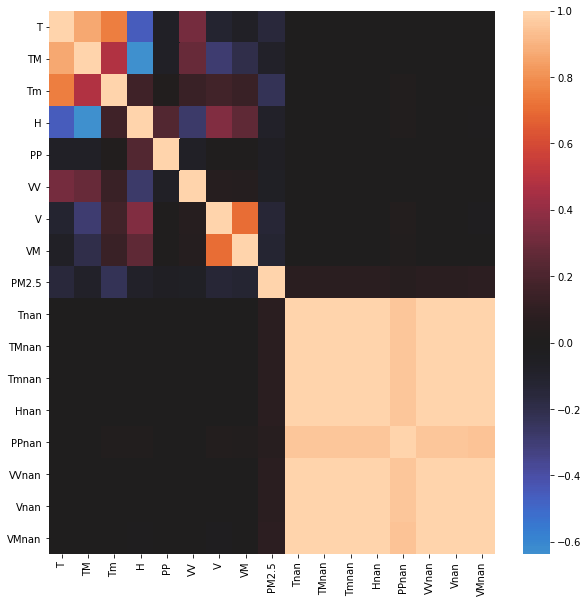

In [7]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(data.corr(),center=0,ax=ax)

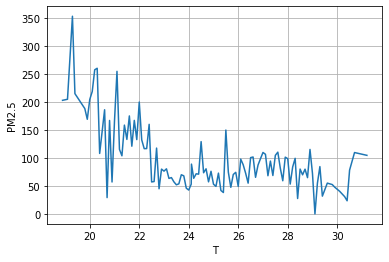

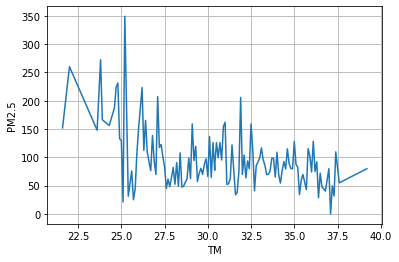

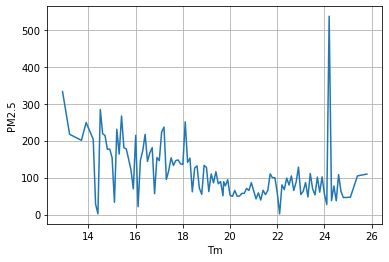

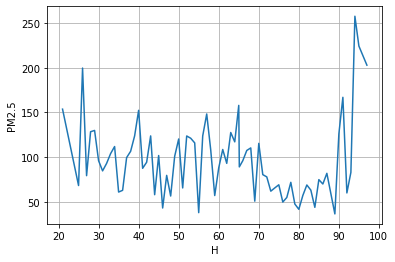

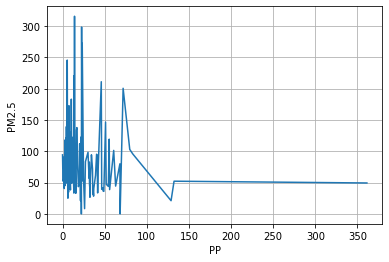

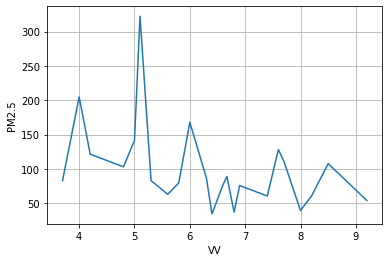

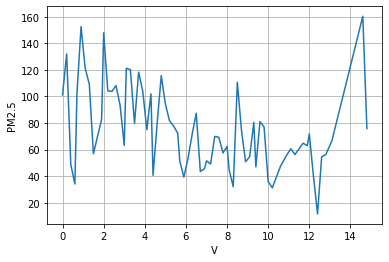

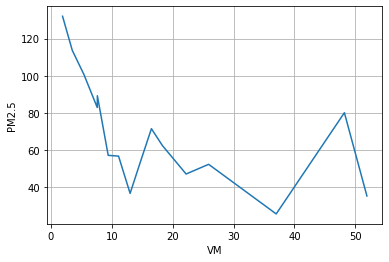

In [8]:
for feature in features:
    dataset=data.copy()
    dataset.groupby(feature)["PM2.5"].median().plot()  
    plt.xlabel(feature)
    plt.ylabel("PM2.5")
    plt.grid()
    plt.show()
    
    

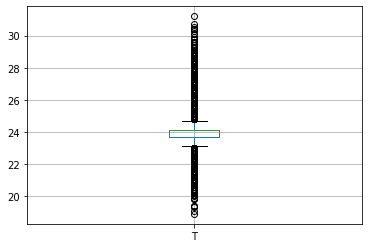

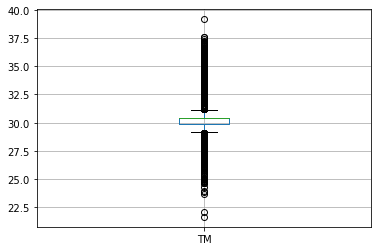

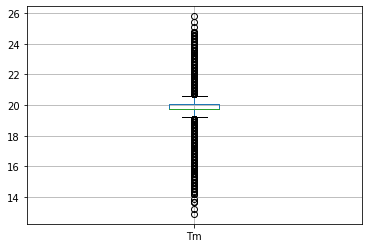

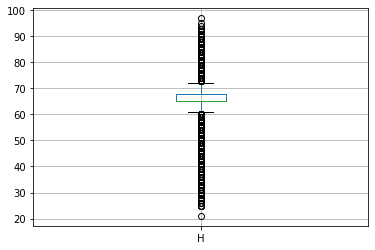

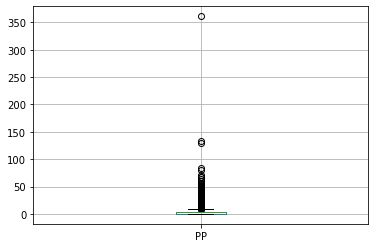

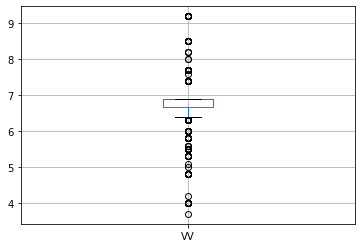

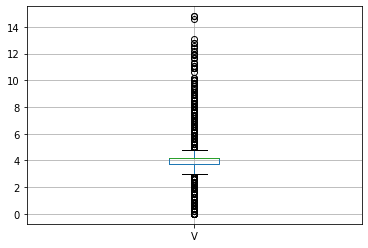

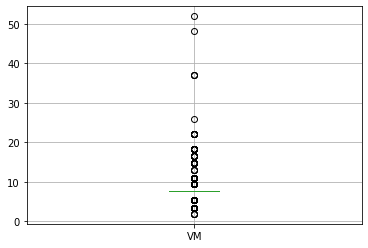

In [9]:
for feature in features:
    data.boxplot(feature)
    plt.show()

In [10]:
for feature in features:
    data[feature]=np.log1p(data[feature])
    

In [11]:
data.columns

Index(['T', 'TM', 'Tm', 'H', 'PP', 'VV', 'V', 'VM', 'PM2.5', 'Tnan', 'TMnan',
       'Tmnan', 'Hnan', 'PPnan', 'VVnan', 'Vnan', 'VMnan'],
      dtype='object')

In [12]:
for feature in features:
    upper=data[feature].mean() + 3*data[feature].std()
    print(upper,feature)
    lower=data[feature].mean() - 3*data[feature].std()
    print(lower,feature)
    data[feature]=np.where(data[feature]>=upper,data[feature]==upper,data[feature])
    
   
                           
                           

3.405199557971196 T
3.0377876026802406 T
3.6338300008362467 TM
3.2565218599124557 TM
3.2626385485578084 Tm
2.7946551100148835 Tm
4.734147198574392 H
3.6185103763813804 H
3.697366970831264 PP
-1.599354696476696 PP
2.225943553559721 VV
1.8446210739101025 VV
2.678479837186124 V
0.49753961401824753 V
2.9834720005667172 VM
1.2339611511429727 VM


In [13]:
data.shape

(2208, 17)

In [14]:
data.isna().sum()

T        0
TM       0
Tm       0
H        0
PP       0
VV       0
V        0
VM       0
PM2.5    0
Tnan     0
TMnan    0
Tmnan    0
Hnan     0
PPnan    0
VVnan    0
Vnan     0
VMnan    0
dtype: int64

In [15]:
data.columns

Index(['T', 'TM', 'Tm', 'H', 'PP', 'VV', 'V', 'VM', 'PM2.5', 'Tnan', 'TMnan',
       'Tmnan', 'Hnan', 'PPnan', 'VVnan', 'Vnan', 'VMnan'],
      dtype='object')

In [16]:
from sklearn.preprocessing import MinMaxScaler ,StandardScaler
scalar1=MinMaxScaler()
feature_scale={'T', 'TM', 'Tm', 'H', 'PP', 'VV', 'V', 'VM', 'Tnan', 'TMnan',
       'Tmnan', 'Hnan', 'PPnan', 'VVnan', 'Vnan', 'VMnan'}


In [17]:
scalar2=StandardScaler()
trans1=scalar1.fit_transform(data[feature_scale])


In [18]:
trans2=scalar2.fit_transform(data[feature_scale])

In [19]:

data=pd.concat([data["PM2.5"],pd.DataFrame(trans1,columns=feature_scale)],axis=1)

In [25]:
data2=pd.concat([data["PM2.5"],pd.DataFrame(trans2,columns=feature_scale)],axis=1)

In [26]:
data=data.dropna()
data2=data2.dropna()

In [31]:
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV,cross_val_score ,train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor ,RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso,Ridge
from sklearn.pipeline import Pipeline


In [29]:
trainX=data.drop("PM2.5",axis=1)
trainy=data["PM2.5"]

In [32]:
pipe =Pipeline([('regressor',Lasso())])
grid_param=[
            {"regressor":[Lasso()],
            "regressor__alpha":[1e-10,1e-20,1e-5,1e-2,1,5,10,50,100],
            "regressor__selection": ['cyclic', 'random']},
            {'regressor':[Ridge()],
            "regressor__alpha":[1e-10,1e-20,1e-5,1e-2,1,5,10,50,100],
            "regressor__solver": ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'],
            "regressor__tol":[1e-3,1e-5,1]},
            {'regressor':[AdaBoostRegressor()],
            'regressor__n_estimators':[50,100,150,200],
            'regressor__learning_rate':[0.05,.1,.5,.7,1,10,100],
            'regressor__loss':['linear', 'square', 'exponential'] },
            {'regressor':[RandomForestRegressor()],
            'regressor__n_estimators':[50,100,150,200],
            'regressor__min_samples_split':[2,4,6,10,14],
            'regressor__min_samples_leaf':[2,0.1,.3,.4],
            'regressor__max_depth':[3,6,9,12,20],
            'regressor__max_features':[ "auto", "sqrt", "log2"]},
            {'regressor':[DecisionTreeRegressor()],
            'regressor__splitter': ["best", "random"],
            'regressor__max_depth':[3,4,5,6,10,15,50,100],
            'regressor__min_samples_split':[2,4,6,10,14],
            'regressor__min_samples_leaf':[2,0.1,.3,.4],
            'regressor__max_features':[2,5,7,10,16]}]

grid=RandomizedSearchCV(pipe,param_distributions=grid_param,cv=10,n_iter=20,scoring="neg_mean_squared_error",verbose=5)


model=grid.fit(trainX,trainy)

Fitting 10 folds for each of 20 candidates, totalling 200 fits
[CV] regressor__splitter=random, regressor__min_samples_split=4, regressor__min_samples_leaf=0.1, regressor__max_features=16, regressor__max_depth=50, regressor=DecisionTreeRegressor() 
[CV]  regressor__splitter=random, regressor__min_samples_split=4, regressor__min_samples_leaf=0.1, regressor__max_features=16, regressor__max_depth=50, regressor=DecisionTreeRegressor(), score=-6004.224, total=   0.1s

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



[CV] regressor__splitter=random, regressor__min_samples_split=4, regressor__min_samples_leaf=0.1, regressor__max_features=16, regressor__max_depth=50, regressor=DecisionTreeRegressor() 
[CV]  regressor__splitter=random, regressor__min_samples_split=4, regressor__min_samples_leaf=0.1, regressor__max_features=16, regressor__max_depth=50, regressor=DecisionTreeRegressor(), score=-8826.401, total=   0.0s
[CV] regressor__splitter=random, regressor__min_samples_split=4, regressor__min_samples_leaf=0.1, regressor__max_features=16, regressor__max_depth=50, regressor=DecisionTreeRegressor() 
[CV]  regressor__splitter=random, regressor__min_samples_split=4, regressor__min_samples_leaf=0.1, regressor__max_features=16, regressor__max_depth=50, regressor=DecisionTreeRegressor(), score=-5839.568, total=   0.0s
[CV] regressor__splitter=random, regressor__min_samples_split=4, regressor__min_samples_leaf=0.1, regressor__max_features=16, regressor__max_depth=50, regressor=DecisionTreeRegressor() 
[CV] 

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s


[CV]  regressor__splitter=random, regressor__min_samples_split=4, regressor__min_samples_leaf=0.1, regressor__max_features=16, regressor__max_depth=50, regressor=DecisionTreeRegressor(), score=-5468.047, total=   0.0s
[CV] regressor__splitter=random, regressor__min_samples_split=4, regressor__min_samples_leaf=0.1, regressor__max_features=16, regressor__max_depth=50, regressor=DecisionTreeRegressor() 
[CV]  regressor__splitter=random, regressor__min_samples_split=4, regressor__min_samples_leaf=0.1, regressor__max_features=16, regressor__max_depth=50, regressor=DecisionTreeRegressor(), score=-9334.371, total=   0.0s
[CV] regressor__splitter=random, regressor__min_samples_split=4, regressor__min_samples_leaf=0.1, regressor__max_features=16, regressor__max_depth=50, regressor=DecisionTreeRegressor() 
[CV]  regressor__splitter=random, regressor__min_samples_split=4, regressor__min_samples_leaf=0.1, regressor__max_features=16, regressor__max_depth=50, regressor=DecisionTreeRegressor(), score

[CV]  regressor__splitter=best, regressor__min_samples_split=2, regressor__min_samples_leaf=0.3, regressor__max_features=16, regressor__max_depth=3, regressor=DecisionTreeRegressor(), score=-6656.422, total=   0.0s
[CV] regressor__splitter=best, regressor__min_samples_split=2, regressor__min_samples_leaf=0.3, regressor__max_features=16, regressor__max_depth=3, regressor=DecisionTreeRegressor() 
[CV]  regressor__splitter=best, regressor__min_samples_split=2, regressor__min_samples_leaf=0.3, regressor__max_features=16, regressor__max_depth=3, regressor=DecisionTreeRegressor(), score=-8269.208, total=   0.1s
[CV] regressor__splitter=best, regressor__min_samples_split=2, regressor__min_samples_leaf=0.3, regressor__max_features=16, regressor__max_depth=3, regressor=DecisionTreeRegressor() 
[CV]  regressor__splitter=best, regressor__min_samples_split=2, regressor__min_samples_leaf=0.3, regressor__max_features=16, regressor__max_depth=3, regressor=DecisionTreeRegressor(), score=-5402.631, tot

[CV]  regressor__tol=1, regressor__solver=lsqr, regressor__alpha=10, regressor=Ridge(), score=-6188.218, total=   0.1s
[CV] regressor__tol=1, regressor__solver=lsqr, regressor__alpha=10, regressor=Ridge() 
[CV]  regressor__tol=1, regressor__solver=lsqr, regressor__alpha=10, regressor=Ridge(), score=-9068.677, total=   0.0s
[CV] regressor__tol=1, regressor__solver=lsqr, regressor__alpha=10, regressor=Ridge() 
[CV]  regressor__tol=1, regressor__solver=lsqr, regressor__alpha=10, regressor=Ridge(), score=-5846.573, total=   0.1s
[CV] regressor__tol=1, regressor__solver=lsqr, regressor__alpha=10, regressor=Ridge() 
[CV]  regressor__tol=1, regressor__solver=lsqr, regressor__alpha=10, regressor=Ridge(), score=-6837.719, total=   0.0s
[CV] regressor__tol=1, regressor__solver=lsqr, regressor__alpha=10, regressor=Ridge() 
[CV]  regressor__tol=1, regressor__solver=lsqr, regressor__alpha=10, regressor=Ridge(), score=-8718.231, total=   0.0s
[CV] regressor__tol=1, regressor__solver=lsqr, regressor_

[CV]  regressor__n_estimators=50, regressor__min_samples_split=14, regressor__min_samples_leaf=0.4, regressor__max_features=log2, regressor__max_depth=9, regressor=RandomForestRegressor(), score=-6470.512, total=   0.3s
[CV] regressor__n_estimators=50, regressor__min_samples_split=14, regressor__min_samples_leaf=0.4, regressor__max_features=log2, regressor__max_depth=9, regressor=RandomForestRegressor() 
[CV]  regressor__n_estimators=50, regressor__min_samples_split=14, regressor__min_samples_leaf=0.4, regressor__max_features=log2, regressor__max_depth=9, regressor=RandomForestRegressor(), score=-8574.669, total=   0.3s
[CV] regressor__n_estimators=50, regressor__min_samples_split=14, regressor__min_samples_leaf=0.4, regressor__max_features=log2, regressor__max_depth=9, regressor=RandomForestRegressor() 
[CV]  regressor__n_estimators=50, regressor__min_samples_split=14, regressor__min_samples_leaf=0.4, regressor__max_features=log2, regressor__max_depth=9, regressor=RandomForestRegresso

[CV]  regressor__n_estimators=200, regressor__min_samples_split=14, regressor__min_samples_leaf=0.4, regressor__max_features=auto, regressor__max_depth=12, regressor=RandomForestRegressor(), score=-8564.060, total=   1.4s
[CV] regressor__n_estimators=200, regressor__min_samples_split=14, regressor__min_samples_leaf=0.4, regressor__max_features=auto, regressor__max_depth=12, regressor=RandomForestRegressor() 
[CV]  regressor__n_estimators=200, regressor__min_samples_split=14, regressor__min_samples_leaf=0.4, regressor__max_features=auto, regressor__max_depth=12, regressor=RandomForestRegressor(), score=-5624.658, total=   1.0s
[CV] regressor__n_estimators=200, regressor__min_samples_split=14, regressor__min_samples_leaf=0.4, regressor__max_features=auto, regressor__max_depth=12, regressor=RandomForestRegressor() 
[CV]  regressor__n_estimators=200, regressor__min_samples_split=14, regressor__min_samples_leaf=0.4, regressor__max_features=auto, regressor__max_depth=12, regressor=RandomFore

[CV]  regressor__n_estimators=200, regressor__min_samples_split=4, regressor__min_samples_leaf=0.4, regressor__max_features=sqrt, regressor__max_depth=6, regressor=RandomForestRegressor(), score=-5626.610, total=   1.0s
[CV] regressor__n_estimators=200, regressor__min_samples_split=4, regressor__min_samples_leaf=0.4, regressor__max_features=sqrt, regressor__max_depth=6, regressor=RandomForestRegressor() 
[CV]  regressor__n_estimators=200, regressor__min_samples_split=4, regressor__min_samples_leaf=0.4, regressor__max_features=sqrt, regressor__max_depth=6, regressor=RandomForestRegressor(), score=-9053.541, total=   0.9s
[CV] regressor__n_estimators=200, regressor__min_samples_split=4, regressor__min_samples_leaf=0.4, regressor__max_features=sqrt, regressor__max_depth=6, regressor=RandomForestRegressor() 
[CV]  regressor__n_estimators=200, regressor__min_samples_split=4, regressor__min_samples_leaf=0.4, regressor__max_features=sqrt, regressor__max_depth=6, regressor=RandomForestRegresso

[CV]  regressor__n_estimators=50, regressor__min_samples_split=10, regressor__min_samples_leaf=0.3, regressor__max_features=sqrt, regressor__max_depth=6, regressor=RandomForestRegressor(), score=-9087.874, total=   0.3s
[CV] regressor__n_estimators=50, regressor__min_samples_split=10, regressor__min_samples_leaf=0.3, regressor__max_features=sqrt, regressor__max_depth=6, regressor=RandomForestRegressor() 
[CV]  regressor__n_estimators=50, regressor__min_samples_split=10, regressor__min_samples_leaf=0.3, regressor__max_features=sqrt, regressor__max_depth=6, regressor=RandomForestRegressor(), score=-5853.029, total=   0.3s
[CV] regressor__n_estimators=50, regressor__min_samples_split=10, regressor__min_samples_leaf=0.3, regressor__max_features=sqrt, regressor__max_depth=6, regressor=RandomForestRegressor() 
[CV]  regressor__n_estimators=50, regressor__min_samples_split=10, regressor__min_samples_leaf=0.3, regressor__max_features=sqrt, regressor__max_depth=6, regressor=RandomForestRegresso

[CV]  regressor__tol=0.001, regressor__solver=sag, regressor__alpha=100, regressor=Ridge(), score=-6477.981, total=   0.1s
[CV] regressor__tol=0.001, regressor__solver=sag, regressor__alpha=100, regressor=Ridge() 
[CV]  regressor__tol=0.001, regressor__solver=sag, regressor__alpha=100, regressor=Ridge(), score=-8465.259, total=   0.0s
[CV] regressor__tol=0.001, regressor__solver=sag, regressor__alpha=100, regressor=Ridge() 
[CV]  regressor__tol=0.001, regressor__solver=sag, regressor__alpha=100, regressor=Ridge(), score=-5541.337, total=   0.1s
[CV] regressor__tol=0.001, regressor__solver=sag, regressor__alpha=100, regressor=Ridge() 
[CV]  regressor__tol=0.001, regressor__solver=sag, regressor__alpha=100, regressor=Ridge(), score=-8987.781, total=   0.0s
[CV] regressor__tol=0.001, regressor__solver=sag, regressor__alpha=100, regressor=Ridge() 
[CV]  regressor__tol=0.001, regressor__solver=sag, regressor__alpha=100, regressor=Ridge(), score=-7765.476, total=   0.1s
[CV] regressor__split

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  1.7min finished


In [33]:
grid.best_params_

{'regressor__n_estimators': 150,
 'regressor__min_samples_split': 14,
 'regressor__min_samples_leaf': 2,
 'regressor__max_features': 'auto',
 'regressor__max_depth': 9,
 'regressor': RandomForestRegressor(max_depth=9, min_samples_leaf=2, min_samples_split=14,
                       n_estimators=150)}

In [34]:
grid.best_score_

-7220.607901819266

In [36]:
reg=RandomForestRegressor(max_depth=9, min_samples_leaf=2, min_samples_split=14,
                       n_estimators=150,max_features="auto")

In [40]:
trainx,train_y,textx,texty=train_test_split(trainX,trainy,random_state=1)

(552,)

In [51]:
reg.fit(trainx,textx)

RandomForestRegressor(max_depth=9, min_samples_leaf=2, min_samples_split=14,
                      n_estimators=150)

In [54]:
pred=reg.predict(train_y)

In [55]:
from sklearn.metrics import mean_squared_error

In [58]:
mean_squared_error(texty,pred)

7804.588269320811

In [59]:
trainX1=data2.drop("PM2.5",axis=1)
trainy1=data2["PM2.5"]

In [60]:
pipe =Pipeline([('regressor',Lasso())])
grid_param=[
            {"regressor":[Lasso()],
            "regressor__alpha":[1e-10,1e-20,1e-5,1e-2,1,5,10,50,100],
            "regressor__selection": ['cyclic', 'random']},
            {'regressor':[Ridge()],
            "regressor__alpha":[1e-10,1e-20,1e-5,1e-2,1,5,10,50,100],
            "regressor__solver": ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'],
            "regressor__tol":[1e-3,1e-5,1]},
            {'regressor':[AdaBoostRegressor()],
            'regressor__n_estimators':[50,100,150,200],
            'regressor__learning_rate':[0.05,.1,.5,.7,1,10,100],
            'regressor__loss':['linear', 'square', 'exponential'] },
            {'regressor':[RandomForestRegressor()],
            'regressor__n_estimators':[50,100,150,200],
            'regressor__min_samples_split':[2,4,6,10,14],
            'regressor__min_samples_leaf':[2,0.1,.3,.4],
            'regressor__max_depth':[3,6,9,12,20],
            'regressor__max_features':[ "auto", "sqrt", "log2"]},
            {'regressor':[DecisionTreeRegressor()],
            'regressor__splitter': ["best", "random"],
            'regressor__max_depth':[3,4,5,6,10,15,50,100],
            'regressor__min_samples_split':[2,4,6,10,14],
            'regressor__min_samples_leaf':[2,0.1,.3,.4],
            'regressor__max_features':[2,5,7,10,16]}]

grid=RandomizedSearchCV(pipe,param_distributions=grid_param,cv=10,n_iter=20,scoring="neg_mean_squared_error",verbose=5)


model=grid.fit(trainX1,trainy1)

Fitting 10 folds for each of 20 candidates, totalling 200 fits
[CV] regressor__splitter=best, regressor__min_samples_split=4, regressor__min_samples_leaf=2, regressor__max_features=16, regressor__max_depth=15, regressor=DecisionTreeRegressor() 
[CV]  regressor__splitter=best, regressor__min_samples_split=4, regressor__min_samples_leaf=2, regressor__max_features=16, regressor__max_depth=15, regressor=DecisionTreeRegressor(), score=-7237.353, total=   0.0s
[CV] regressor__splitter=best, regressor__min_samples_split=4, regressor__min_samples_leaf=2, regressor__max_features=16, regressor__max_depth=15, regressor=DecisionTreeRegressor() 
[CV]  regressor__splitter=best, regressor__min_samples_split=4, regressor__min_samples_leaf=2, regressor__max_features=16, regressor__max_depth=15, regressor=DecisionTreeRegressor(), score=-11804.316, total=   0.1s
[CV] regressor__splitter=best, regressor__min_samples_split=4, regressor__min_samples_leaf=2, regressor__max_features=16, regressor__max_depth=1

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s


[CV]  regressor__splitter=best, regressor__min_samples_split=4, regressor__min_samples_leaf=2, regressor__max_features=16, regressor__max_depth=15, regressor=DecisionTreeRegressor(), score=-9439.630, total=   0.0s
[CV] regressor__splitter=best, regressor__min_samples_split=4, regressor__min_samples_leaf=2, regressor__max_features=16, regressor__max_depth=15, regressor=DecisionTreeRegressor() 
[CV]  regressor__splitter=best, regressor__min_samples_split=4, regressor__min_samples_leaf=2, regressor__max_features=16, regressor__max_depth=15, regressor=DecisionTreeRegressor(), score=-11091.837, total=   0.0s
[CV] regressor__splitter=best, regressor__min_samples_split=4, regressor__min_samples_leaf=2, regressor__max_features=16, regressor__max_depth=15, regressor=DecisionTreeRegressor() 
[CV]  regressor__splitter=best, regressor__min_samples_split=4, regressor__min_samples_leaf=2, regressor__max_features=16, regressor__max_depth=15, regressor=DecisionTreeRegressor(), score=-10093.143, total=

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


[CV]  regressor__splitter=best, regressor__min_samples_split=4, regressor__min_samples_leaf=2, regressor__max_features=16, regressor__max_depth=15, regressor=DecisionTreeRegressor(), score=-11168.059, total=   0.0s
[CV] regressor__splitter=best, regressor__min_samples_split=4, regressor__min_samples_leaf=2, regressor__max_features=16, regressor__max_depth=15, regressor=DecisionTreeRegressor() 
[CV]  regressor__splitter=best, regressor__min_samples_split=4, regressor__min_samples_leaf=2, regressor__max_features=16, regressor__max_depth=15, regressor=DecisionTreeRegressor(), score=-9813.356, total=   0.1s
[CV] regressor__n_estimators=150, regressor__min_samples_split=2, regressor__min_samples_leaf=0.4, regressor__max_features=sqrt, regressor__max_depth=6, regressor=RandomForestRegressor() 
[CV]  regressor__n_estimators=150, regressor__min_samples_split=2, regressor__min_samples_leaf=0.4, regressor__max_features=sqrt, regressor__max_depth=6, regressor=RandomForestRegressor(), score=-6110.

[CV]  regressor__n_estimators=200, regressor__min_samples_split=14, regressor__min_samples_leaf=0.1, regressor__max_features=auto, regressor__max_depth=12, regressor=RandomForestRegressor(), score=-7451.139, total=   1.9s
[CV] regressor__splitter=random, regressor__min_samples_split=2, regressor__min_samples_leaf=2, regressor__max_features=10, regressor__max_depth=3, regressor=DecisionTreeRegressor() 
[CV]  regressor__splitter=random, regressor__min_samples_split=2, regressor__min_samples_leaf=2, regressor__max_features=10, regressor__max_depth=3, regressor=DecisionTreeRegressor(), score=-5970.041, total=   0.0s
[CV] regressor__splitter=random, regressor__min_samples_split=2, regressor__min_samples_leaf=2, regressor__max_features=10, regressor__max_depth=3, regressor=DecisionTreeRegressor() 
[CV]  regressor__splitter=random, regressor__min_samples_split=2, regressor__min_samples_leaf=2, regressor__max_features=10, regressor__max_depth=3, regressor=DecisionTreeRegressor(), score=-9015.7

[CV]  regressor__n_estimators=200, regressor__min_samples_split=14, regressor__min_samples_leaf=2, regressor__max_features=auto, regressor__max_depth=9, regressor=RandomForestRegressor(), score=-5475.202, total=   3.5s
[CV] regressor__n_estimators=200, regressor__min_samples_split=14, regressor__min_samples_leaf=2, regressor__max_features=auto, regressor__max_depth=9, regressor=RandomForestRegressor() 
[CV]  regressor__n_estimators=200, regressor__min_samples_split=14, regressor__min_samples_leaf=2, regressor__max_features=auto, regressor__max_depth=9, regressor=RandomForestRegressor(), score=-8957.802, total=   2.8s
[CV] regressor__n_estimators=200, regressor__min_samples_split=14, regressor__min_samples_leaf=2, regressor__max_features=auto, regressor__max_depth=9, regressor=RandomForestRegressor() 
[CV]  regressor__n_estimators=200, regressor__min_samples_split=14, regressor__min_samples_leaf=2, regressor__max_features=auto, regressor__max_depth=9, regressor=RandomForestRegressor(), 

[CV]  regressor__n_estimators=150, regressor__min_samples_split=6, regressor__min_samples_leaf=0.4, regressor__max_features=log2, regressor__max_depth=6, regressor=RandomForestRegressor(), score=-9039.582, total=   1.0s
[CV] regressor__n_estimators=150, regressor__min_samples_split=6, regressor__min_samples_leaf=0.4, regressor__max_features=log2, regressor__max_depth=6, regressor=RandomForestRegressor() 
[CV]  regressor__n_estimators=150, regressor__min_samples_split=6, regressor__min_samples_leaf=0.4, regressor__max_features=log2, regressor__max_depth=6, regressor=RandomForestRegressor(), score=-5867.122, total=   1.2s
[CV] regressor__n_estimators=150, regressor__min_samples_split=6, regressor__min_samples_leaf=0.4, regressor__max_features=log2, regressor__max_depth=6, regressor=RandomForestRegressor() 
[CV]  regressor__n_estimators=150, regressor__min_samples_split=6, regressor__min_samples_leaf=0.4, regressor__max_features=log2, regressor__max_depth=6, regressor=RandomForestRegresso

[CV] regressor__splitter=random, regressor__min_samples_split=6, regressor__min_samples_leaf=0.1, regressor__max_features=16, regressor__max_depth=5, regressor=DecisionTreeRegressor() 
[CV]  regressor__splitter=random, regressor__min_samples_split=6, regressor__min_samples_leaf=0.1, regressor__max_features=16, regressor__max_depth=5, regressor=DecisionTreeRegressor(), score=-5561.666, total=   0.0s
[CV] regressor__splitter=random, regressor__min_samples_split=6, regressor__min_samples_leaf=0.1, regressor__max_features=16, regressor__max_depth=5, regressor=DecisionTreeRegressor() 
[CV]  regressor__splitter=random, regressor__min_samples_split=6, regressor__min_samples_leaf=0.1, regressor__max_features=16, regressor__max_depth=5, regressor=DecisionTreeRegressor(), score=-9248.672, total=   0.0s
[CV] regressor__splitter=random, regressor__min_samples_split=6, regressor__min_samples_leaf=0.1, regressor__max_features=16, regressor__max_depth=5, regressor=DecisionTreeRegressor() 
[CV]  regre

[CV] regressor__splitter=random, regressor__min_samples_split=10, regressor__min_samples_leaf=2, regressor__max_features=7, regressor__max_depth=15, regressor=DecisionTreeRegressor() 
[CV]  regressor__splitter=random, regressor__min_samples_split=10, regressor__min_samples_leaf=2, regressor__max_features=7, regressor__max_depth=15, regressor=DecisionTreeRegressor(), score=-6427.331, total=   0.0s
[CV] regressor__splitter=random, regressor__min_samples_split=10, regressor__min_samples_leaf=2, regressor__max_features=7, regressor__max_depth=15, regressor=DecisionTreeRegressor() 
[CV]  regressor__splitter=random, regressor__min_samples_split=10, regressor__min_samples_leaf=2, regressor__max_features=7, regressor__max_depth=15, regressor=DecisionTreeRegressor(), score=-9079.525, total=   0.0s
[CV] regressor__splitter=random, regressor__min_samples_split=10, regressor__min_samples_leaf=2, regressor__max_features=7, regressor__max_depth=15, regressor=DecisionTreeRegressor() 
[CV]  regressor_

[CV]  regressor__splitter=random, regressor__min_samples_split=4, regressor__min_samples_leaf=0.1, regressor__max_features=5, regressor__max_depth=5, regressor=DecisionTreeRegressor(), score=-5581.877, total=   0.0s
[CV] regressor__splitter=random, regressor__min_samples_split=4, regressor__min_samples_leaf=0.1, regressor__max_features=5, regressor__max_depth=5, regressor=DecisionTreeRegressor() 
[CV]  regressor__splitter=random, regressor__min_samples_split=4, regressor__min_samples_leaf=0.1, regressor__max_features=5, regressor__max_depth=5, regressor=DecisionTreeRegressor(), score=-9217.904, total=   0.0s
[CV] regressor__splitter=random, regressor__min_samples_split=4, regressor__min_samples_leaf=0.1, regressor__max_features=5, regressor__max_depth=5, regressor=DecisionTreeRegressor() 
[CV]  regressor__splitter=random, regressor__min_samples_split=4, regressor__min_samples_leaf=0.1, regressor__max_features=5, regressor__max_depth=5, regressor=DecisionTreeRegressor(), score=-7886.499

[CV]  regressor__n_estimators=150, regressor__min_samples_split=4, regressor__min_samples_leaf=2, regressor__max_features=auto, regressor__max_depth=6, regressor=RandomForestRegressor(), score=-8560.595, total=   1.5s
[CV] regressor__n_estimators=150, regressor__min_samples_split=4, regressor__min_samples_leaf=2, regressor__max_features=auto, regressor__max_depth=6, regressor=RandomForestRegressor() 
[CV]  regressor__n_estimators=150, regressor__min_samples_split=4, regressor__min_samples_leaf=2, regressor__max_features=auto, regressor__max_depth=6, regressor=RandomForestRegressor(), score=-7865.028, total=   1.6s
[CV] regressor__splitter=best, regressor__min_samples_split=10, regressor__min_samples_leaf=0.4, regressor__max_features=2, regressor__max_depth=15, regressor=DecisionTreeRegressor() 
[CV]  regressor__splitter=best, regressor__min_samples_split=10, regressor__min_samples_leaf=0.4, regressor__max_features=2, regressor__max_depth=15, regressor=DecisionTreeRegressor(), score=-61

[CV]  regressor__n_estimators=200, regressor__min_samples_split=2, regressor__min_samples_leaf=0.4, regressor__max_features=log2, regressor__max_depth=9, regressor=RandomForestRegressor(), score=-5860.886, total=   1.0s
[CV] regressor__n_estimators=200, regressor__min_samples_split=2, regressor__min_samples_leaf=0.4, regressor__max_features=log2, regressor__max_depth=9, regressor=RandomForestRegressor() 
[CV]  regressor__n_estimators=200, regressor__min_samples_split=2, regressor__min_samples_leaf=0.4, regressor__max_features=log2, regressor__max_depth=9, regressor=RandomForestRegressor(), score=-6830.260, total=   1.0s
[CV] regressor__n_estimators=200, regressor__min_samples_split=2, regressor__min_samples_leaf=0.4, regressor__max_features=log2, regressor__max_depth=9, regressor=RandomForestRegressor() 
[CV]  regressor__n_estimators=200, regressor__min_samples_split=2, regressor__min_samples_leaf=0.4, regressor__max_features=log2, regressor__max_depth=9, regressor=RandomForestRegresso

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  2.2min finished


In [61]:
grid.best_params_

{'regressor__n_estimators': 200,
 'regressor__min_samples_split': 14,
 'regressor__min_samples_leaf': 0.1,
 'regressor__max_features': 'auto',
 'regressor__max_depth': 12,
 'regressor': RandomForestRegressor(max_depth=12, min_samples_leaf=0.1, min_samples_split=14,
                       n_estimators=200)}

In [62]:
grid.best_score_

-7067.584038018217

In [63]:
reg2=RandomForestRegressor(max_depth=12, min_samples_leaf=0.1, min_samples_split=14,
                       n_estimators=200)

In [83]:
train_X,text_X,train_y,text_y=train_test_split(trainX,trainy,test_size=0.30,random_state=1)

In [84]:
train_X.shape

(1544, 16)

In [85]:
train_y.shape

(1544,)

In [86]:
reg2.fit(train_X,train_y)

RandomForestRegressor(max_depth=12, min_samples_leaf=0.1, min_samples_split=14,
                      n_estimators=200)

In [87]:
pred=reg2.predict(text_X)

In [90]:
mean_squared_error(text_y,pred)

7331.418917919236